### Train ETH data to CNN generative network

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import torch
if torch.cuda.device_count():
    device = 'cuda'
    print('Good to go')
else:
    device = 'cpu'
    print('Using cpu')

Good to go


In [2]:
from ReadData import ReadETHFolder, ReadETHFile
foldername="./ETH_Data/v/"
currentname = "./ETH_Data/"+"currents_3787.h5"
file_num = 1000
data_shape = (16,16,16,3)
Bfield = torch.tensor(ReadETHFolder(foldername,file_num, data_shape)).permute(0,4,1,2,3)
current = torch.tensor(ReadETHFile(currentname))
current = current[0:Bfield.shape[0],:]


In [3]:
print(Bfield.shape)
print(current.shape)

torch.Size([1000, 3, 16, 16, 16])
torch.Size([1000, 8])


In [4]:
print(Bfield.shape)
print(Bfield.mean()*1e3)
print(Bfield.var())
print(Bfield.std()*1e3)

torch.Size([1000, 3, 16, 16, 16])
tensor(-0.4876, dtype=torch.float64)
tensor(0.0031, dtype=torch.float64)
tensor(55.3219, dtype=torch.float64)


In [5]:
#data normalization
#find min and max value of input position and Bfield
max_current, max_current_index = torch.max(current, dim=0, keepdim=True)
# print(max_current)
min_current, min_current_index = torch.min(current, dim=0, keepdim=True)
# print(min_current)

max_Bfield, max_Bfield_index = torch.max(Bfield.transpose(0,1).reshape(3,-1), dim=1, keepdim=True)
print(max_Bfield)
min_Bfield, min_Bfield_index = torch.min(Bfield.transpose(0,1).reshape(3,-1), dim=1, keepdim=True)
print(min_Bfield)

dimB = Bfield.shape
dimc = current.shape

minB=min_Bfield.expand(3,int(Bfield.numel()/3)).reshape(3,dimB[0],dimB[2],dimB[3],dimB[4]).transpose(0,1)
maxB=max_Bfield.expand(3,int(Bfield.numel()/3)).reshape(3,dimB[0],dimB[2],dimB[3],dimB[4]).transpose(0,1)

ave_current=0.5*(max_current.expand(dimc[0],dimc[1])+min_current.expand(dimc[0],dimc[1]))
diff_current=0.5*(max_current.expand(dimc[0],dimc[1])-min_current.expand(dimc[0],dimc[1]))

current_norm = (current-ave_current)/diff_current
Bfield_norm = (Bfield-(minB+maxB)*0.5)/(0.5*(maxB-minB))

print(min_current.shape)
print(max_current.shape)
print(min_Bfield.shape)
print(max_Bfield.shape)

torch.save(min_current, "./normalize_data/cnn_min_current_ETH.pt")
torch.save(max_current, "./normalize_data/cnn_max_current_ETH.pt")
torch.save(min_Bfield, "./normalize_data/cnn_min_Bfield_ETH.pt")
torch.save(max_Bfield, "./normalize_data/cnn_max_Bfield_ETH.pt")

tensor([[0.4591],
        [0.4241],
        [0.3447]], dtype=torch.float64)
tensor([[-0.4902],
        [-0.4390],
        [-0.3529]], dtype=torch.float64)
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([3, 1])
torch.Size([3, 1])


In [6]:
MaxB=maxB.cuda(0)
MinB=minB.cuda(0)
print(MaxB.device)
print(MinB.device)

cuda:0
cuda:0


In [9]:
from Neural_network import Generative_net, Generative_net_test, ResidualEMNSBlock_3d, BigBlock, weight_init, eMNS_Dataset
from Training_loop import train_part_GM,get_mean_of_dataloader
from tqdm import tqdm

###############################################
# Config the neural network
###############################################
num_input = 8
output_shape = (3,16,16,16)
SB_args = (64,64,4,1) # (Cin, Cout, num_repeat, num_block)
BB_args = (2,3) # (scale_factor, num_block)
SB_block = ResidualEMNSBlock_3d 
BB_block = BigBlock
DF = False # whether using divergence free model

Generative_network = Generative_net(SB_args, BB_args, SB_block, BB_block, num_input=num_input, output_shape= output_shape)
print(Generative_network)

Generative_net(
  (proj): Linear(in_features=8, out_features=512, bias=True)
  (conv3d): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (total_net): Sequential(
    (0): Linear(in_features=8, out_features=512, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(64, 2, 2, 2))
    (2): BigBlock(
      (block): Sequential(
        (0): ResidualEMNSBlock_3d(
          (block): Sequential(
            (0): Sequential(
              (0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
              (2): LeakyReLU(negative_slope=0.01)
            )
            (1): Sequential(
              (0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
              (2): LeakyReLU(negative_slope=0.01)
            )
        

In [11]:
from Neural_network import Generative_net, Generative_net_test, ResidualEMNSBlock_3d, BigBlock, weight_init, eMNS_Dataset
from Training_loop import train_part_GM,get_mean_of_dataloader
from tqdm import tqdm

batch_size = 8
# construct dataset
dataset = eMNS_Dataset(
    train_x=current_norm,
    train_y=Bfield_norm
)
###############################################
# Config the neural network
###############################################
num_input = 8
output_shape = (3,16,16,16)
SB_args = (64,64,4,1) # (Cin, Cout, num_repeat, num_block)
BB_args = (2,3) # (scale_factor, num_block)
SB_block = ResidualEMNSBlock_3d 
BB_block = BigBlock
DF = False # whether using divergence free model

Generative_network = Generative_net_test(SB_args, BB_args, SB_block, BB_block, num_input=num_input, output_shape= output_shape)
epochs = 400
learning_rate_decay = .5
learning_rates = [1e-4]
RMSE_lr = []
schedule = []
linear_lr = False
weight_decays = [0]

train_percents = np.arange(1.0,1.01,0.1)
RMSE_history_end = np.zeros(len(train_percents))
RMSE_val_history_end = np.zeros(len(train_percents))
loss_history_end = np.zeros(len(train_percents))
iter_history_end = np.zeros(len(train_percents))
mse_history_end = np.zeros(len(train_percents))
mse_val_history_end = np.zeros(len(train_percents))
train_stop_epoch = np.zeros(len(train_percents))

################################################
# Train the neural network
################################################
index=0
for train_percent in train_percents:
    epoch_stop = 0
    print('train_percent',train_percent)
    for learning_rate in tqdm(learning_rates):
        for weight_decay in weight_decays:

            # split the dataset to train, validation, test
            train_set, valid_set = torch.utils.data.random_split(dataset, [0.9,0.1])

            #Using Dataloader for batch train
            train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
            valid_loader = torch.utils.data.DataLoader(dataset=valid_set,batch_size=batch_size,shuffle=True)

            get_mean_of_dataloader(valid_loader,model=Generative_network,device=device)
            print("----------------------------")
            
            print("----------------------------")
            # test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=True)

            Generative_network.apply(weight_init)
            optimizer = torch.optim.Adam([{'params':Generative_network.parameters()}], lr=learning_rate, weight_decay= weight_decay, betas=(0.5,0.99))
            RMSE_history, RMSE_val_history, loss_history, iter_history, mse_history, mse_val_history,epoch_stop,Rsquare,loss_train,loss_val= train_part_GM(
                model=Generative_network, optimizer=optimizer, train_loader=train_loader, valid_loader=valid_loader, epochs=epochs, 
                learning_rate_decay=learning_rate_decay, weight_decay=weight_decay, schedule=schedule, grid_space=dimB[2]*dimB[3]*dimB[4], DF=DF,verbose=False, device=device, maxB=MaxB[0,:], minB=MinB[0,:],
                lr_max=learning_rate, lr_min=2.5e-7,max_epoch=epochs, linear_lr=linear_lr)
        

        RMSE_lr.append(RMSE_val_history[epoch_stop].item())
    
    #save RMSE and loss after early stopping
    RMSE_history_end[index] = RMSE_history[epoch_stop]
    RMSE_val_history_end[index]= RMSE_val_history[epoch_stop]
    loss_history_end[index] = loss_history[epoch_stop]
    iter_history_end[index] = iter_history[epoch_stop]
    mse_history_end[index] = mse_history[epoch_stop]
    mse_val_history_end[index] = mse_val_history[epoch_stop]
    index=index+1
    print('training stop at epoch:',epoch_stop)
    print('training stop at epoch:',Rsquare)
torch.save(Generative_network, 'EMS_CNN.pt')	# 这里会存储迄今最优模型的参数
print(RMSE_lr)
print(learning_rates)
print(RMSE_lr[0],learning_rates[0])


train_percent 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

----------------------------
----------------------------
epoch================================================= 0
Epoch 0, Iteration 113, loss = 0.1980
Got rmse 53.307647459989475
Got rmse 55.00926298170465

epoch================================================= 1
Epoch 1, Iteration 226, loss = 0.1151
Got rmse 39.85169455475838
Got rmse 41.32518665232658

epoch================================================= 2
Epoch 2, Iteration 339, loss = 0.0732
Got rmse 32.15676724549757
Got rmse 33.01039050782147

epoch================================================= 3
Epoch 3, Iteration 452, loss = 0.1512
Got rmse 33.534520270727654
Got rmse 34.84276393904622

epoch================================================= 4
Epoch 4, Iteration 565, loss = 0.0927
Got rmse 23.638272851936833
Got rmse 24.257171078098125

epoch================================================= 5
Epoch 5, Iteration 678, loss = 0.0988
Got rmse 41.10285985017295
Got rmse 41.66384598701767

epoch=================================

100%|██████████| 1/1 [07:05<00:00, 425.83s/it]

Got rmse 0.9658403963464829

training stop at epoch: 399
training stop at epoch: tensor(0.9995, device='cuda:0', dtype=torch.float64)
[1.1505104303359985]
[0.0001]
1.1505104303359985 0.0001


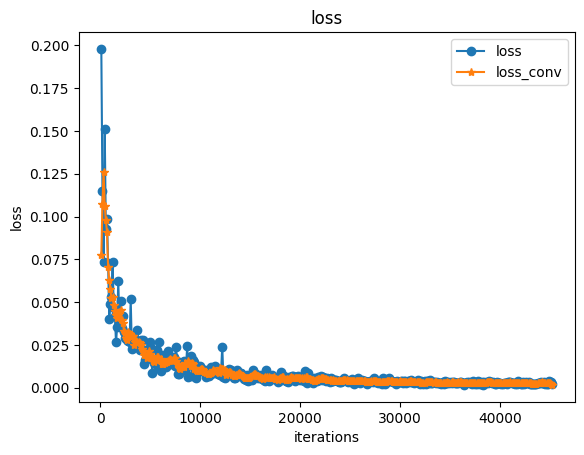

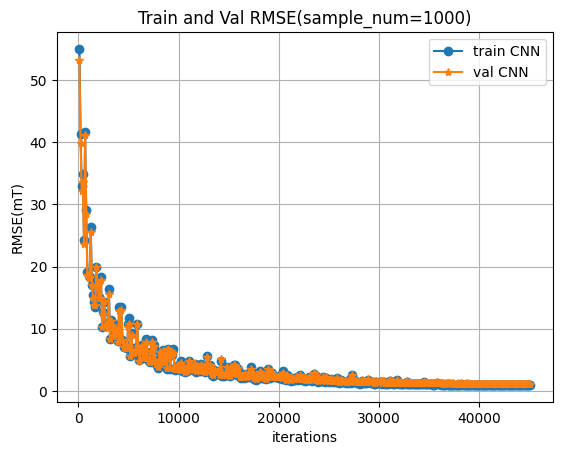

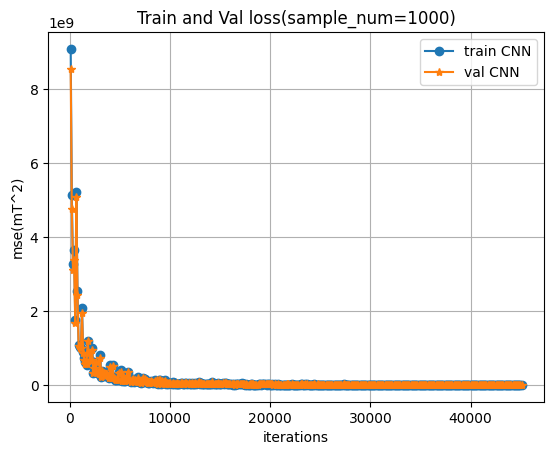

399


In [13]:
import matplotlib.pyplot as plt
import numpy as np
ave_site = 5
ave_kernel = 1/ave_site*np.ones(ave_site)
loss_history_conv = np.convolve(loss_history.numpy(),ave_kernel,'same')


plt.title('loss')
plt.plot(iter_history,loss_history,'-o')
plt.plot(iter_history,loss_history_conv,'-*')
plt.legend(['loss','loss_conv'])
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

plt.title('Train and Val RMSE(sample_num=1000)')
plt.plot(iter_history[0:epoch_stop],RMSE_history[0:epoch_stop],'-o')
plt.plot(iter_history[0:epoch_stop],RMSE_val_history[0:epoch_stop],'-*')
# plt.plot(2e-5*np.arange(epoch_stop),RMSE_history[0:epoch_stop]*1000,'-o')
# plt.plot(2e-5*np.arange(epoch_stop),RMSE_val_history[0:epoch_stop]*1000,'-*')
# plt.ylim([3,80])
plt.legend(['train CNN','val CNN'])
plt.xlabel('iterations')
plt.ylabel('RMSE(mT)')
plt.grid()
plt.show()

plt.title('Train and Val loss(sample_num=1000)')
plt.plot(iter_history[0:epoch_stop],mse_history[0:epoch_stop]*1e6,'-o')
plt.plot(iter_history[0:epoch_stop],mse_val_history[0:epoch_stop]*1e6,'-*')
plt.legend(['train CNN','val CNN'])
plt.xlabel('iterations')
plt.ylabel('mse(mT^2)')
plt.grid()
plt.show()
print(epoch_stop)


In [14]:
torch.save(Generative_network, 'EMS_CNN_ETH.pt')	# 这里会存储迄今最优模型的参数